## What relationships exist between type of admission, admission diagnosis, length of stay, age, gender, readmittance within 30 days, amount of bedside attention (e.g. patient is bathed), and occurence of sepsis?

EDA: Pairplot with every pairing of the eight attributes mentioned above. The data from ADMISSIONS, PATIENTS, and CHARTEVENTS would have to be merged and derived attributes added. The data would be primarily segmented by ADMISSIONS record. Visualization: Seaborn.

In [1]:
# Imports for DFs & connecting to Postgres
import pandas as pd
import psycopg2

- Xtype of admission -> admissions.admission_type
- Xadmission diagnosis -> admissions.diagnosis
- Xlength of stay -> admissions.dischtime minus admissions.admittime
- Xreadmittance within 30 days -> admissions.admittime? (will have to calculate for each admission whether another admission took place within 30 days)
- ?age -> patients.dob (will have to calculate age at time of admission)
- Xgender -> patients.gender
- !amount of bedside attention (e.g. patient is bathed) -> chartevents.itemid.label
- Xoccurence of sepsis -> multiple

### Pull in Admissions data

In [2]:
# Connect to Postgres & get all records for ADMISSIONS
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT * FROM mimiciii.admissions;""")
    con.commit()
    print('OK')
except Exception as e:
    print(e)  

OK


In [3]:
# Store ADMISSIONS result in var
admissions_all = cur.fetchall()

In [4]:
# Convert ADMISSIONS result to DF
admissions_df = pd.DataFrame(admissions_all, columns = ['row_id','subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
 'admission_type', 'admission_location', 'discharge_location',
 'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
 'has_chartevents_data'])

In [5]:
# Create shortened DF of relevant cols
admissions_short = admissions_df[['subject_id', 'hadm_id', 'admission_type', 'diagnosis', 'dischtime', 'admittime', 'hospital_expire_flag']]

### Pull in Patients data

In [6]:
# Connect to Postgres & get all records for PATIENTS
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT * FROM mimiciii.patients;""")
    con.commit()
    print('OK')
except Exception as e:
    print(e)

OK


In [7]:
# Store PATIENTS result in var
patients_all = cur.fetchall()

In [8]:
# Convert PATIENTS result to DF
patients_df = pd.DataFrame(patients_all, columns = ['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag'])

In [9]:
# Create shortened DF of relevant cols
patients_short = patients_df[['subject_id', 'gender', 'dob']]

### Merge Patient details onto Admissions

In [10]:
# Merge shortened Patients DF onto shortened Admissions DF using 'subject_id'
adm_pat_merge = admissions_short.merge(patients_short, how='left', on='subject_id')

In [11]:
# Create new col to indicate length of stay, type is Timedelta
adm_pat_merge['adm_los'] = adm_pat_merge['dischtime']-adm_pat_merge['admittime']

In [12]:
# Add new col that converts timedelta to seconds & then to hours
adm_pat_merge['adm_los_hrs'] = adm_pat_merge['adm_los'].apply(lambda x: ((x.seconds)+(x.days*86400))/3600)

In [13]:
adm_pat_merge.head()

,subject_id,hadm_id,admission_type,diagnosis,dischtime,admittime,hospital_expire_flag,gender,dob,adm_los,adm_los_hrs
0,22,165315,EMERGENCY,BENZODIAZEPINE OVERDOSE,2196-04-10 15:54:00,2196-04-09 12:26:00,0,F,2131-05-07,1 days 03:28:00,27.466667
1,23,152223,ELECTIVE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,2153-09-08 19:10:00,2153-09-03 07:15:00,0,M,2082-07-17,5 days 11:55:00,131.916667
2,23,124321,EMERGENCY,BRAIN MASS,2157-10-25 14:00:00,2157-10-18 19:34:00,0,M,2082-07-17,6 days 18:26:00,162.433333
3,24,161859,EMERGENCY,INTERIOR MYOCARDIAL INFARCTION,2139-06-09 12:48:00,2139-06-06 16:14:00,0,M,2100-05-31,2 days 20:34:00,68.566667
4,25,129635,EMERGENCY,ACUTE CORONARY SYNDROME,2160-11-05 14:55:00,2160-11-02 02:06:00,0,M,2101-11-21,3 days 12:49:00,84.816667


In [14]:
# adm_pat_merge.drop('adm_los_hrs'<0)
# df = df.drop(df[df.score < 50].index)
# adm_pat_merge = adm_pat_merge.drop(adm_pat_merge[adm_pat_merge['adm_los_hrs'] < 0].index, inplace= True)

### Pull ICD9 codes for Sepsis

In [15]:
# Connect to Postgres & get all d_icd_diagnoses where short or long title indicates 'sepsis' or 'septicemia'
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT icd9_code, short_title, long_title
	FROM mimiciii.d_icd_diagnoses
	WHERE long_title LIKE ANY(ARRAY['Sepsi%', 'Septi%','sepsi%', 'septi%', 'Severe sepsis', 'severe sepsis', 'Puerperal sep%', 'puerperal sep%']) OR
	short_title LIKE ANY(ARRAY['Sepsi%', 'Septi%','sepsi%', 'septi%', 'Severe sepsis', 'severe sepsis', 'Puerperal sep%', 'puerperal sep%']);""")
    con.commit()
    print('OK')
except Exception as e:
    print(e)  

OK


In [16]:
# Store ICD9_CODE result in var
sepsis_all = cur.fetchall()

In [17]:
# Convert ICD9_CODE result to DF
sepsis_df = pd.DataFrame(sepsis_all, columns = ['icd9_code', 'short_title', 'long_title'])

In [18]:
# Get list of relevant ICD9 codes, just here for reference since it's pasted below
sepsis_codes_list = sepsis_df['icd9_code'].to_list()
# sepsis_codes_list

### Pull Diagnoses ICD data to find admissions with sepsis

In [19]:
# Connect to Postgres & get all admissions where a sepsis code was used
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT hadm_id, icd9_code
	FROM mimiciii.diagnoses_icd
	WHERE icd9_code = ANY(ARRAY['0383',
 '03840',
 '03841',
 '03842',
 '03843',
 '03844',
 '0388',
 '0389',
 '0202',
 '449',
 '41512',
 '42292',
 '65930',
 '65931',
 '65933',
 '77181',
 '99591',
 '99592',
 '78552',
 '67020',
 '67022',
 '67024',
 '67030',
 '67032',
 '67034']);""")
    con.commit()
    print('OK')
except Exception as e:
    print(e)

OK


In [20]:
# Store DIAGNOSES_ICD result in var
adm_sepsis_all = cur.fetchall()

In [21]:
# Convert DIAGNOSES_ICD result to DF
adm_sepsis_df = pd.DataFrame(adm_sepsis_all, columns = ['hadm_id', 'icd9_code'])

In [22]:
# Create DF that contains every admission where sepsis was diagnosed & tally number of those diagnoses for the given admission
adm_sepsis_cnt = adm_sepsis_df.groupby(by='hadm_id').agg({'icd9_code':'count'})
# Rename column to 'sepsis_count'
adm_sepsis_cnt.rename(columns={'icd9_code':'sepsis_count'}, inplace=True)

### Merge count of sepsis into admission-patient DF

In [23]:
# Create new merged DF with admissions, patient, & sepsis count data
adm_pat_sep = adm_pat_merge.merge(adm_sepsis_cnt, how='left', on='hadm_id')
# Convert NaNs in 'sepsis_count' to zeroes
adm_pat_sep['sepsis_count'].fillna(value=0, inplace=True)

In [24]:
# Add col converting gender to 0/1
adm_pat_sep['gender_binary'] = adm_pat_sep['gender'].apply(lambda x: 1 if x=='M' else 0)

In [25]:
# Add col flagging admission type = emergency
adm_pat_sep['emergency_flag'] = adm_pat_sep['admission_type'].apply(lambda x: 1 if x == 'EMERGENCY' else 0)

In [26]:
# Add col flagging admission type = elective
adm_pat_sep['elective_flag'] = adm_pat_sep['admission_type'].apply(lambda x: 1 if x == 'ELECTIVE' else 0)

### Pull D_ITEMS data related to "bedside patient care"

In [27]:
# Connect to Postgres & get all d_items where label indicates "bedside patient care"
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT itemid, label
	FROM mimiciii.d_items
	WHERE label LIKE ANY(ARRAY['Dressing','Dressing Applied%','Dressing Change','Dressing change','catheter reposi%',
    'Catheter','bath%','show%','shav%', 'teeth%', 'bedbath', 'bed/bath%','activi%', 'Food%']);""")
    con.commit()
    print('OK')
except Exception as e:
    print(e)  

OK


In [28]:
# Store D_ITEMS result in var
items_care_all = cur.fetchall()

In [29]:
# Convert D_ITEMS result to DF
items_care_df = pd.DataFrame(items_care_all, columns = ['itemid', 'label'])

In [30]:
# Get list of relevant itemids, just here for reference since it's pasted below
items_care_list = items_care_df['itemid'].to_list()

### Get all "bedside patient care" entries from CHARTEVENTS

In [31]:
# Connect to Postgres & get all chartevents where itemid matches those from "bedside patient care" list
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT subject_id, hadm_id, icustay_id, itemid
	FROM mimiciii.chartevents
	WHERE itemid = ANY(ARRAY[1053,
 1063,
 1066,
 1202,
 5548,
 7896,
 4605,
 1382,
 3058,
 5678,
 3013,
 3014,
 6269,
 7652,
 44555,
 228482,
 227955]);""")
    con.commit()
    print('OK')
except Exception as e:
    print(e) 

OK


In [32]:
# Store CHARTEVENTS result in var
chart_care_all = cur.fetchall()

In [33]:
chart_care_all

[]

### Not finding any "bedside patient care" entries in Chartevents, strange.

### Get count of chartevents per admission

In [34]:
# Connect to Postgres & get counts of CHARTEVENTS for each admission record
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT hadm_id,  count(hadm_id)
	FROM mimiciii.chartevents
	GROUP BY chartevents.hadm_id;""")
    con.commit()
    print('OK')
except Exception as e:
    print(e)

OK


In [35]:
# Store CHARTEVENTS result in var
chartevents_count_all = cur.fetchall()

In [36]:
# Convert CHARTEVENTS result to DF
chartevents_count_df = pd.DataFrame(chartevents_count_all, columns = ['hadm_id', 'chartevents_count'])

In [37]:
# Merge chartevents DF into existing DF, create new DF
adm_pat_sep_char = adm_pat_sep.merge(chartevents_count_df, how='left', on='hadm_id')
adm_pat_sep_char['chartevents_count'].fillna(value=0, inplace=True)

### Get 30 day readmits

In [38]:
# Connect to Postgres & get all records for ADMISSIONS with just subject_id & admittime
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT subject_id, admittime FROM mimiciii.admissions;""")
    con.commit()
    print('OK')
except Exception as e:
    print(e) 

OK


In [39]:
# Store ADMISSIONS result in var
adm_subj_all = cur.fetchall()

In [40]:
# Create dict where key is subject_id and value is a list of all their admittimes
from collections import defaultdict 
subj_admitt_dict = defaultdict(list)
for k, v in adm_subj_all:
    subj_admitt_dict[k].append(v)

In [41]:
# Connect to Postgres & get all records for ADMISSIONS
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT subject_id, hadm_id, admittime FROM mimiciii.admissions;""")
    con.commit()
    print('OK')
except Exception as e:
    print(e) 

OK


In [42]:
# Store ADMISSIONS result in var
admissions_id_all = cur.fetchall()

In [43]:
import datetime

In [44]:
#Pythonic way of getting 30 day readmits
hadm_readmits = []
for i in admissions_id_all:
    subject_id = i[0]
    hadm_id = i[1]
    admittime = i[2]
    
    other_admits = subj_admitt_dict[subject_id]
    
    thirty_days = datetime.timedelta(days=30)
    one_min = datetime.timedelta(minutes=1)
    
    if len(other_admits) > 1:
        for j in other_admits:
            diff = j - admittime
            if diff >= one_min and diff <= thirty_days:
                hadm_readmits.append(hadm_id)

In [45]:
# Convert 30 day readmits to DF
hadm_readmits_df = pd.DataFrame(hadm_readmits, columns = ['hadm_id'])
hadm_readmits_df['readmit_30'] = 1

In [46]:
# Merge 30 day readmits to existing DF & create new DF for pair plot
pairplot_df = adm_pat_sep_char.merge(hadm_readmits_df, how='left', on='hadm_id')
pairplot_df['readmit_30'].fillna(value=0, inplace=True)

In [47]:
pairplot_df.drop(columns=['subject_id', 'hadm_id', 'diagnosis', 'admittime', 'dischtime', 'gender', 'dob', 'adm_los'], inplace= True)
pairplot_df.head()

,admission_type,hospital_expire_flag,adm_los_hrs,sepsis_count,gender_binary,emergency_flag,elective_flag,chartevents_count,readmit_30
0,EMERGENCY,0,27.466667,0.0,0,1,0,0.0,0.0
1,ELECTIVE,0,131.916667,0.0,1,0,1,0.0,0.0
2,EMERGENCY,0,162.433333,0.0,1,1,0,640.0,0.0
3,EMERGENCY,0,68.566667,0.0,1,1,0,0.0,0.0
4,EMERGENCY,0,84.816667,0.0,1,1,0,0.0,0.0


In [48]:
bry_test = pairplot_df[pairplot_df['adm_los_hrs']<0]

In [49]:
len(bry_test)

98

In [50]:
pairplot_df_test = pairplot_df[['hospital_expire_flag', 'adm_los_hrs', 'sepsis_count', 'gender_binary', 'emergency_flag', 'elective_flag', 'chartevents_count', 'readmit_30']]

### Create pairplot of vars

In [51]:
import seaborn as sns

C:\Users\bcrom\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


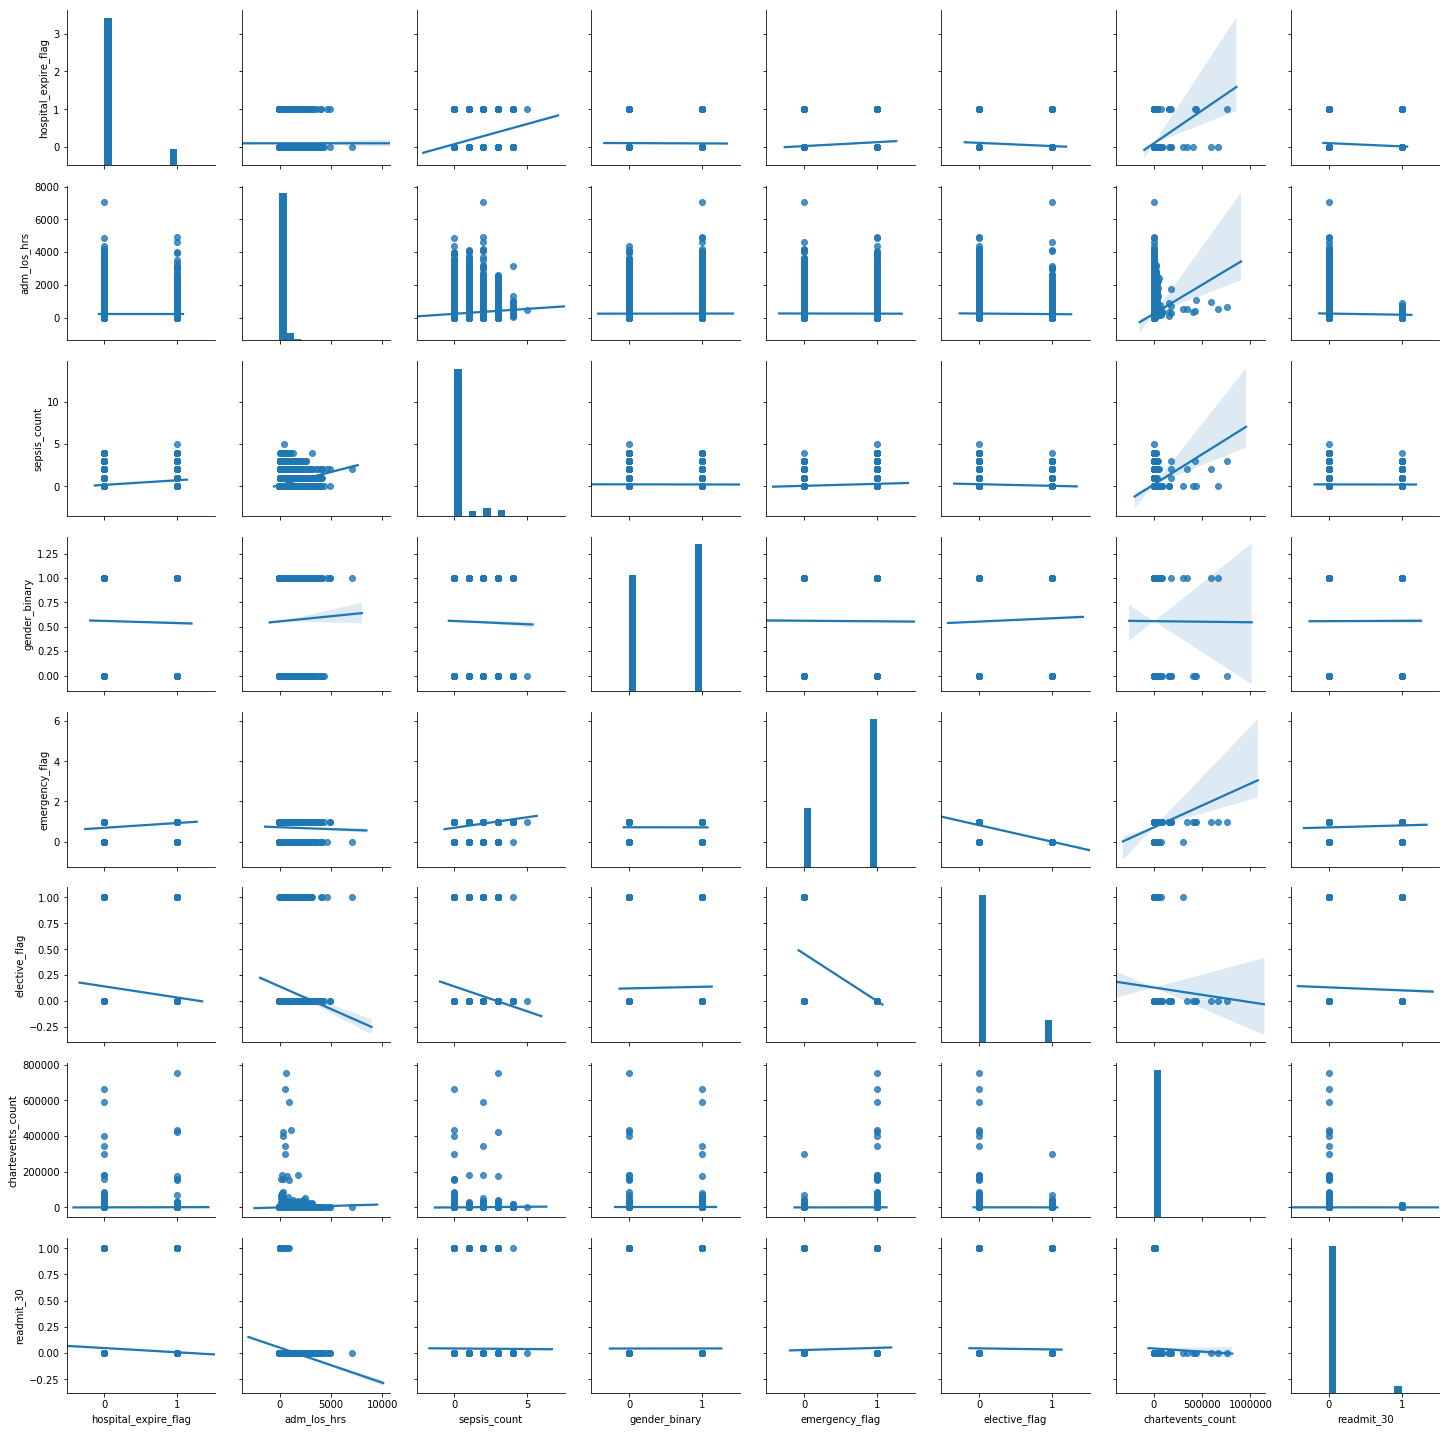

In [52]:
# Generate pair plot
# sns.pairplot(pairplot_df, kind="reg", hue="admission_type");
sns.pairplot(pairplot_df_test, kind="reg");